## NYC Parking Violations - Detailed Analysis and a Prediction Model

### Eren Tümkaya - tumkaya19@itu.edu.tr


In [138]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import calendar



### Getting the Data

New York City has a really nice website where most of its open data can be found easily. I used the relatively new and large dataset "Parking Violations Issued". The link to the open data site and to my dataset is [here](https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2023/869v-vr48) for anyone interested.

The site lets me access the data in various ways. I prefer to pull it using the "API" of the dataset. For that, I read the API document really carefully, checked which columns I will be using and also used paginating to retrieve it.  

Paginating is pulling the data in multiple requests instead of one. I used this because I believe it is more suitable for a large dataset.It will potentially help me with avoiding timeouts, problems with memory usage and overall performance. Again, the parameters of the API's can differ. Hence, reading the documentation is a must. For this dataset, "API" documentation can be found [here](https://dev.socrata.com/foundry/data.cityofnewyork.us/869v-vr48). 



In [4]:
url = "https://data.cityofnewyork.us/resource/869v-vr48.json"
params = {
    '$select': 'summons_number,issue_date,violation_time,violation_code,vehicle_color,vehicle_body_type,vehicle_make,vehicle_year,unregistered_vehicle,violation_county,registration_state'

    '$limit': 100000,
    '$offset': 0  
}

all_data = []

while True:
    response = requests.get(url, params=params)
    
    try:
        response.raise_for_status()
        data = response.json()
        if not data:
            break  
        all_data.extend(data)
        params['$offset'] += len(data)
    except requests.exceptions.HTTPError as error1:
        print(f"HTTP Error: {error1}")
        break
    except requests.exceptions.ConnectionError as error2:
        print(f"Error Connecting: {error2}")
        break
    except requests.exceptions.Timeout as error3:
        print(f"Timeout Error: {error3}")
        break
    except requests.exceptions.RequestException as error4:
        print(f"An error occurred: {error4}")
        break
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        break

raw_dataset = pd.DataFrame(all_data)


In [5]:
raw_dataset

,summons_number,issue_date,violation_time,violation_code,vehicle_color,vehicle_body_type,vehicle_make,vehicle_year,unregistered_vehicle,violation_county,registration_state
0,1484697303,2022-06-10T00:00:00.000,1037A,67,BLK,SDN,TOYOT,2004,0,NY,NY
1,1484697315,2022-06-13T00:00:00.000,1045A,51,GRAY,SUBN,JEEP,2017,0,NY,NY
2,1484697625,2022-06-19T00:00:00.000,1116A,63,GRAY,SDN,JEEP,0,0,NY,NJ
3,1484697674,2022-06-19T00:00:00.000,1052A,63,NaN,SUBN,LEXUS,0,0,NY,NY
4,1484697686,2022-06-19T00:00:00.000,1107A,63,BLUE,SDN,HYUND,0,0,NY,NJ
...,...,...,...,...,...,...,...,...,...,...,...
21563253,9081757568,2023-09-26T00:00:00.000,1207P,21,GY,SUBN,SUBAR,2021,NaN,NY,NY
21563254,9081822305,2023-09-22T00:00:00.000,0354P,20,BK,SUBN,JEEP,2016,NaN,BX,NY
21563255,9081860008,2023-09-16T00:00:00.000,1231P,40,GY,4DSD,INFIN,2021,NaN,K,NY
21563256,9081880056,2023-09-26T00:00:00.000,1015A,21,WH,4DSD,CADIL,2014,NaN,K,NY


In [6]:
raw_dataset.to_csv('C:\\EREN\\Datasets\\NYC_raw_data.csv')

In [7]:
raw_dataset.to_parquet('C:\\EREN\\Datasets\\NYC_raw_data.parquet')

In [46]:
raw_dataset=pd.read_csv('C:\\EREN\\Datasets\\NYC_raw_data.csv')

In [47]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21563258 entries, 0 to 21563257
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Unnamed: 0            int64  
 1   summons_number        int64  
 2   issue_date            object 
 3   violation_time        object 
 4   violation_code        int64  
 5   vehicle_color         object 
 6   vehicle_body_type     object 
 7   vehicle_make          object 
 8   vehicle_year          int64  
 9   unregistered_vehicle  float64
 10  violation_county      object 
 11  registration_state    object 
dtypes: float64(1), int64(4), object(7)
memory usage: 1.9+ GB


## Cleaning the Data

### The Date

In [48]:
raw_dataset["issue_date"]

0           2022-06-10T00:00:00.000
1           2022-06-13T00:00:00.000
2           2022-06-19T00:00:00.000
3           2022-06-19T00:00:00.000
4           2022-06-19T00:00:00.000
                     ...           
21563253    2023-09-26T00:00:00.000
21563254    2023-09-22T00:00:00.000
21563255    2023-09-16T00:00:00.000
21563256    2023-09-26T00:00:00.000
21563257    2023-09-25T00:00:00.000
Name: issue_date, Length: 21563258, dtype: object

I will convert the column to date format in order to perform operations easily.

In [49]:
raw_dataset['issue_date'] = pd.to_datetime(raw_dataset['issue_date'])

In [50]:
raw_dataset["issue_date"]

0          2022-06-10
1          2022-06-13
2          2022-06-19
3          2022-06-19
4          2022-06-19
              ...    
21563253   2023-09-26
21563254   2023-09-22
21563255   2023-09-16
21563256   2023-09-26
21563257   2023-09-25
Name: issue_date, Length: 21563258, dtype: datetime64[ns]

As indicated in the documentation, this dataset provides data on "Parking Violations" issued between July 1, 2022 to June 30, 2023. However, I noticed that it also includes some datas before and after these dates. I wanted to solely focus on the data mentioned on the documentation. Hence, I will delete the rest.

In [51]:
raw_dataset = raw_dataset[(raw_dataset["issue_date"] >= "2022-07-01") & (raw_dataset["issue_date"] <= "2023-06-30")]



In [52]:
raw_dataset.reset_index(drop=True, inplace=True)

In [53]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17245270 entries, 0 to 17245269
Data columns (total 12 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Unnamed: 0            int64         
 1   summons_number        int64         
 2   issue_date            datetime64[ns]
 3   violation_time        object        
 4   violation_code        int64         
 5   vehicle_color         object        
 6   vehicle_body_type     object        
 7   vehicle_make          object        
 8   vehicle_year          int64         
 9   unregistered_vehicle  float64       
 10  violation_county      object        
 11  registration_state    object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 1.5+ GB


It looks better now. I move on to the next.

### The Hour 

I will start the hour column. One of the first things that I want to see is the hourly trend of parking tickets. Hence, it is an important task for me to clean it enough to be able to perform my analysis.

In [54]:
raw_dataset["violation_time"]

0           1102A
1           1132A
2           1135A
3           0235P
4           0156P
            ...  
17245265    1022P
17245266    0300A
17245267    0639P
17245268    0220A
17245269    0205A
Name: violation_time, Length: 17245270, dtype: object

There are several things that I want to do with this column. Firstly, I want to turn all these values to 24h system. Then, I will change the datatype.  

Before I move on, I want to see how many missing data points I have.

In [55]:
raw_dataset[raw_dataset["violation_time"].isnull()]

,Unnamed: 0,summons_number,issue_date,violation_time,violation_code,vehicle_color,vehicle_body_type,vehicle_make,vehicle_year,unregistered_vehicle,violation_county,registration_state
338,1208,1471587850,2022-07-04,NaN,20,GY,SDN,HYUND,2020,0.0,Q,NY
2577,8818,1487702670,2022-07-07,NaN,40,BLK,SUBN,ACURA,0,0.0,Q,PA
300261,399340,1487614482,2022-07-14,NaN,78,WH,VAN,ISUZU,0,0.0,Q,NJ
328072,437035,1487881447,2022-07-02,NaN,74,BLK,NaN,BMW,0,0.0,NaN,99
995193,1299436,1485279677,2022-08-03,NaN,21,GRAY,P-U,CHEVR,2006,0.0,K,NY
...,...,...,...,...,...,...,...,...,...,...,...,...
17087459,17739077,1490352909,2023-06-07,NaN,46,WHT,VAN,FORD,2015,0.0,NaN,NY
17088190,17740326,1471957809,2023-06-24,NaN,40,BLK,SUBN,LEXUS,2016,0.0,K,NY
17243613,19143495,1491941078,2023-06-01,NaN,20,NaN,SDN,BMW,0,0.0,NaN,99
17243745,19147150,1492270880,2023-06-21,NaN,46,BLK,SUBN,KIA,0,0.0,NY,NY


It is quite nice to see that I don't have many. 173 rows out of 21 million is negligible. I will delete them and continue my analysis.

In [56]:
raw_dataset.dropna(subset=["violation_time"], inplace=True)

In [57]:
raw_dataset["violation_time"].isnull().sum()

0

Now, I will perform the transformation I mentioned. For this, I will define a function first. This function helps me getting rid of PM's and AM's also returning the hour for the earliest hour. 

For instance, 10.37A will be returned as 10.00 and 09.57P will be returned as 21.00. This will help me with grouping, that is the idea behind.  

*** After some inspection, I realised that there were also rows like "0000P", "0034A" etc. I don't think it is common in US to represent the hour like that but there were many tickets time labeled like this. So I prepared my function to be able to handle all of them.

Below, I wanted to show what I was talking about.


In [58]:
filtered_rows = raw_dataset[raw_dataset['violation_time'].str.startswith("00")]


In [149]:
filtered_rows

violation_county
K     22968
NY    10101
Q      5383
BX     4706
R       141
Name: count, dtype: int64

Now, I will write the function to perform this transformation.

In [95]:
def convert_and_round(hour_str):
    try:
        hour, minute = hour_str[:-1][:2], hour_str[:-1][2:]
    
        if hour_str[-1] == 'P':
            if hour != '12':
                hour = str(int(hour) + 12)
        elif hour_str[-1] == 'A' and hour == '12':
            hour = '00'
    
        
        return f'{hour.zfill(2)}:00'
    except ValueError:
        return hour_str

In [94]:
convert_and_round("0027P")

'12:00'

In [82]:
convert_and_round("1220P")

'24:00'

In [99]:
convert_and_round("0020A")

'00:00'

In [100]:
convert_and_round("0320A")

'03:00'

It seems as if it is working perfectly. I will apply it to our dataframe now.

In [96]:
raw_dataset["violation_time"]=raw_dataset["violation_time"].apply(convert_and_round)

In [101]:
raw_dataset

,Unnamed: 0,summons_number,issue_date,violation_time,violation_code,vehicle_color,vehicle_body_type,vehicle_make,vehicle_year,unregistered_vehicle,violation_county,registration_state
0,12,1484699750,2023-06-19,11:00,63,WHT,SUBN,CHEVR,2010,0.0,NY,NY
1,16,1484720581,2022-07-03,11:00,68,WHT,VAN,CHRYS,0,0.0,R,FL
2,17,1484720600,2022-07-03,11:00,68,WHT,SUBN,CHEVR,0,0.0,R,NJ
3,20,1484721329,2022-07-04,14:00,20,GL,SUBN,SUBAR,2016,0.0,R,NY
4,21,1484721330,2022-07-04,13:00,20,WHITE,SUBN,ME/BE,2019,0.0,R,NY
...,...,...,...,...,...,...,...,...,...,...,...,...
17245265,21165497,1492958694,2022-08-26,22:00,99,BLU,SDN,HONDA,2007,0.0,Q,PA
17245266,21165528,1492976532,2023-06-04,03:00,51,BLUE,SUBN,JEEP,0,0.0,Q,NY
17245267,21166959,1487347315,2023-06-04,18:00,46,NaN,SUBN,CHRYS,0,0.0,NaN,NY
17245268,21168681,1488236902,2022-11-19,02:00,98,BLK,SUBN,CHEVR,2022,0.0,K,NY


I will perform grouping to see if it looks fine.

In [106]:
raw_dataset.groupby(["issue_date","violation_time"]).size().sort_index().head(24)

issue_date  violation_time
2022-07-01  00:00              426
            01:00              533
            02:00              407
            03:00              245
            04:00              149
            05:00              457
            06:00             2381
            07:00             3553
            08:00             5999
            09:00             5888
            10:00             4392
            11:00             5729
            12:00             5106
            13:00             4555
            14:00             4614
            15:00             3799
            16:00             3377
            17:00             2897
            18:00             2277
            19:00             1889
            20:00             1707
            21:00             1421
            22:00              329
            23:00              265
dtype: int64

It looks really good. There are some which are probably wrong imputs and I will drop them.

In [117]:
raw_dataset.groupby("violation_time").size().sort_index().head(35)

violation_time
.1:00          1
00:00     280161
01:00     270939
02:00     212097
03:00     181406
04:00     169762
05:00     259492
06:00     540066
07:00     952984
08:00    1471612
09:00    1503656
10:00    1223646
11:00    1503414
12:00    1395900
13:00    1346455
14:00    1194043
15:00     998139
16:00     800483
17:00     692311
18:00     506686
19:00     384778
20:00     384651
21:00     361539
22:00     317452
23:00     293396
25:00          1
26:00          1
27:00          2
28:00          1
29:00          1
30:00          1
31:00          1
32:00          1
43:00          1
45:00          2
dtype: int64

I will use regular expressions to remove all the rest. 

In [118]:
filter1 = raw_dataset["violation_time"].str.match(r'^([01]\d|2[0-3]):00$')
filtered_dataset = raw_dataset[filter1]

Lastly, I want to convert my column datatype to categorical. I also want them to be ordered so I defined "ordered categories".

In [120]:
ordered_categories = ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']

filtered_dataset["violation_time"] = pd.Categorical(filtered_dataset["violation_time"], categories=ordered_categories, ordered=True)

C:\Users\erent\AppData\Local\Temp\ipykernel_27176\1078268269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset["violation_time"] = pd.Categorical(filtered_dataset["violation_time"], categories=ordered_categories, ordered=True)


In [121]:
filtered_dataset.groupby("violation_time").size()

violation_time
00:00     280161
01:00     270939
02:00     212097
03:00     181406
04:00     169762
05:00     259492
06:00     540066
07:00     952984
08:00    1471612
09:00    1503656
10:00    1223646
11:00    1503414
12:00    1395900
13:00    1346455
14:00    1194043
15:00     998139
16:00     800483
17:00     692311
18:00     506686
19:00     384778
20:00     384651
21:00     361539
22:00     317452
23:00     293396
dtype: int64

I believe I am done with this feature as well.

## Initial Analysis

Since the date and hour features are cleaned now, I wanted to visualize them to gain some first insight on the data.

### Average Count of Parking Violations Each Hour

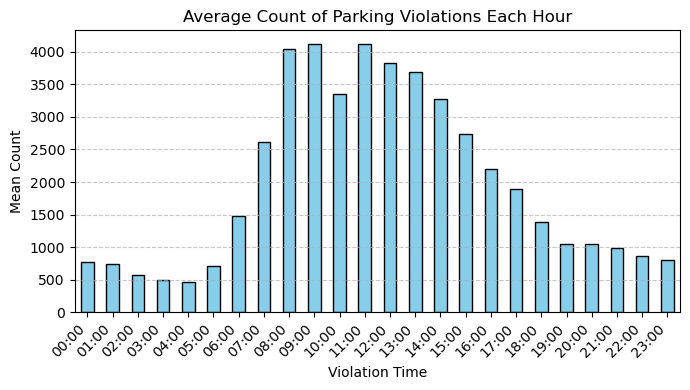

In [130]:
grouped_data = filtered_dataset.groupby(["issue_date", "violation_time"]).size().groupby("violation_time").mean()


fig, ax = plt.subplots(figsize=(7, 4))

grouped_data.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)


ax.set_xlabel('Violation Time')
ax.set_ylabel('Mean Count')
ax.set_title('Average Count of Parking Violations Each Hour')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45, ha='right') 
plt.tight_layout()

plt.show()

### Monthly Parking Violations

In [144]:
filtered_dataset = filtered_dataset.sort_values(by='issue_date')


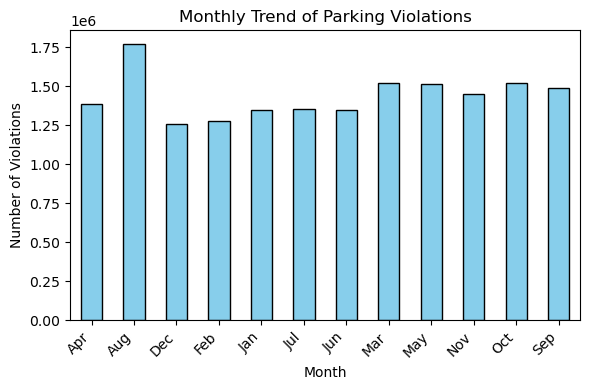

In [146]:
filtered_dataset['month'] = filtered_dataset['issue_date'].dt.month.apply(lambda x: calendar.month_abbr[x])

monthly = filtered_dataset.groupby('month').size()

fig, ax = plt.subplots(figsize=(6, 4))

monthly.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)

ax.set_xlabel('Month')
ax.set_ylabel('Number of Violations')
ax.set_title('Monthly Trend of Parking Violations')

plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

plt.show()

### Violations by County

<Axes: xlabel='violation_county'>

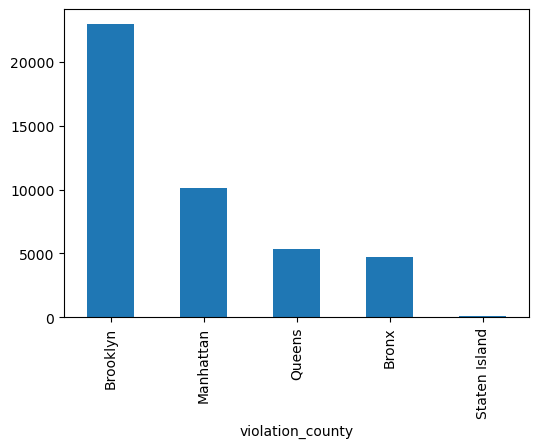

In [178]:
filtered_rows["violation_county"].replace({"K":"Brooklyn","NY":"Manhattan","Q":"Queens","BX":"Bronx","R":"Staten Island"}).value_counts().plot(kind="bar",figsize=(6,4))

# trying something- to be deleted

In [163]:

url="https://data.cityofnewyork.us/resource/869v-vr48.json"
response=requests.get(url)
data=response.json()
df=pd.DataFrame(data)
df.head()


,summons_number,plate_id,registration_state,plate_type,issue_date,violation_code,vehicle_body_type,vehicle_make,issuing_agency,street_code1,...,days_parking_in_effect,from_hours_in_effect,to_hours_in_effect,vehicle_color,unregistered_vehicle,vehicle_year,meter_number,feet_from_curb,house_number,time_first_observed
0,1484697303,JER1863,NY,PAS,2022-06-10T00:00:00.000,67,SDN,TOYOT,P,34330,...,BBBBBBB,ALL,ALL,BLK,0,2004,-,0,NaN,NaN
1,1484697315,KEV4487,NY,PAS,2022-06-13T00:00:00.000,51,SUBN,JEEP,K,34310,...,BBBBBBB,ALL,ALL,GRAY,0,2017,-,0,436,NaN
2,1484697625,H73NYD,NJ,PAS,2022-06-19T00:00:00.000,63,SDN,JEEP,N,30640,...,BBBBBBB,ALL,ALL,GRAY,0,0,-,0,109,NaN
3,1484697674,GJC9296,NY,PAS,2022-06-19T00:00:00.000,63,SUBN,LEXUS,N,30640,...,BBBBBBB,ALL,ALL,NaN,0,0,-,0,109,NaN
4,1484697686,M51PUV,NJ,PAS,2022-06-19T00:00:00.000,63,SDN,HYUND,N,30640,...,BBBBBBB,ALL,ALL,BLUE,0,0,-,0,109,NaN


In [166]:
df["street_code1"].value_counts()

street_code1
0        136
54580     19
30430     18
23880     13
19010     12
        ... 
38190      1
28970      1
37468      1
38210      1
7140       1
Name: count, Length: 492, dtype: int64

In [168]:
df["street_code2"].value_counts()

street_code2
0        148
40404     73
24980     14
23800     13
12550     12
        ... 
26070      1
45020      1
14720      1
55220      1
27990      1
Name: count, Length: 455, dtype: int64

In [171]:
df["violation_location"].value_counts()

violation_location
45     96
69     56
110    49
114    47
23     44
       ..
99      1
64      1
28      1
119     1
174     1
Name: count, Length: 75, dtype: int64